In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [43]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [44]:
count = (df['smoking_history'] == 'No Info').sum()
print(count)

print(df['smoking_history'].value_counts())

diabetes = ((df['diabetes'] == 1) & (df['smoking_history'] == 'No Info')).sum()
print(f"diabetes count {diabetes}")

35816
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
diabetes count 1454


In [45]:
rows = len(df)

drop_percent = count/rows
drop_percent

0.35816

In [46]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data


,Total,Percent
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
smoking_history,0,0.0
bmi,0,0.0
HbA1c_level,0,0.0
blood_glucose_level,0,0.0
diabetes,0,0.0


As we can see based off of the fact that we have no null values for any of our columns we do not need to apply any sort of handling of our missing data. In this case if we were to have missing data for age, bmi, HbA1c_level, blood_glucose_level we would take the medium values inside of these columns and input that for the missing values as this is best practice in our case.

Here we can create a label encoder to encode all of our categorical data. This will correspond to never smoking = 4, former smoker = 3, not current smoker = 2, current smoker = 1, no info = 0

In [47]:
le = LabelEncoder()
df["smoking_encoded"] = le.fit_transform(df["smoking_history"])
encoded = le.fit_transform(df['smoking_encoded'])
df.head(15)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,4
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,4
3,Female,36.0,0,0,current,23.45,5.0,155,0,1
4,Male,76.0,1,1,current,20.14,4.8,155,0,1
5,Female,20.0,0,0,never,27.32,6.6,85,0,4
6,Female,44.0,0,0,never,19.31,6.5,200,1,4
7,Female,79.0,0,0,No Info,23.86,5.7,85,0,0
8,Male,42.0,0,0,never,33.64,4.8,145,0,4
9,Female,32.0,0,0,never,27.32,5.0,100,0,4


We can also get rid of the gender category and dummy encode it, knowing that if we have 

In [48]:
df = pd.get_dummies(df, columns=["gender"], drop_first=True)
df.drop(columns=["gender_Other"], inplace=True)
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True
...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,No Info,27.32,6.2,90,0,0,False
99996,2.0,0,0,No Info,17.37,6.5,100,0,0,False
99997,66.0,0,0,former,27.83,5.7,155,0,3,True
99998,24.0,0,0,never,35.42,4.0,100,0,4,False


<function matplotlib.pyplot.show(close=None, block=None)>

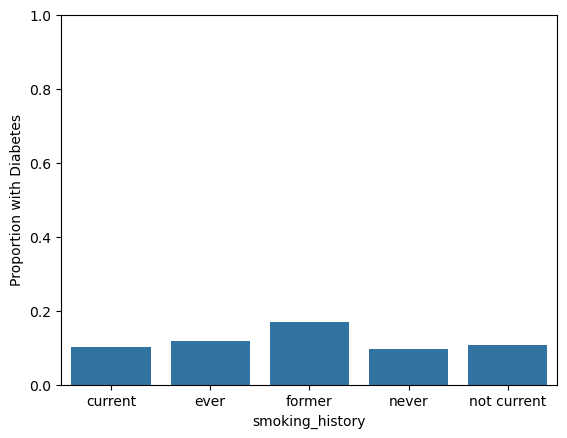

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = df.groupby('smoking_history')['diabetes'].mean().reset_index()

sns.barplot(x='smoking_history', y='diabetes', data=grouped)
plt.ylabel('Proportion with Diabetes')
plt.ylim(0,1)
plt.show

In [69]:
df.drop(df[df['smoking_history'] == 'No Info'].index, inplace=True)
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True
5,20.0,0,0,never,27.32,6.6,85,0,4,False
...,...,...,...,...,...,...,...,...,...,...
99992,26.0,0,0,never,34.34,6.5,160,0,4,False
99993,40.0,0,0,never,40.69,3.5,155,0,4,False
99997,66.0,0,0,former,27.83,5.7,155,0,3,True
99998,24.0,0,0,never,35.42,4.0,100,0,4,False


In [77]:
df[df['smoking_encoded'] == 0].sum()

(64184, 10)

In [84]:
print("Categorical Columns Mode Frequency")
cat_columns = df.select_dtypes(include=["object"]).columns
mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])
mode_freq_df.head
for col in cat_columns:
    mode_value = df[col].mode().iat[0]
    mode_freq = (df[col] == mode_value).mean()
# create a new row at the next integer index
mode_freq_df.loc[len(mode_freq_df)] = [col, mode_freq]
print(mode_freq_df.sort_values("mode_frequency", ascending=False).head(10))

Categorical Columns Mode Frequency
       column_name  mode_frequency
0  smoking_history        0.546787
